# Fine-Tune Whisper For Akan ASR with HuggingFace Transformers

## Preparing Environment

In [1]:
# A distributed environment for DeepSpeed. This emulates a launcher in the notebook
import os

os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9994"
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

/kaggle/input
/kaggle/input/akan-audio-2000
/kaggle/input/akan-audio-2000/random_2000_audio
/kaggle/input/deepspeed-config


In [3]:
def count_files(directory):
    # List all files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return len(files)

# Replace 'your_directory_path' with the path to the folder
directory_path = "/kaggle/input/akan-audio-2000/random_2000_audio"
print(f"Number of files: {count_files(directory_path)}")



Number of files: 2000


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Sep 18 13:38:03 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import torch

if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [6]:

print(torch.version.cuda)

12.3


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
%%capture

!pip install --upgrade --quiet pip
!pip install --upgrade --quiet datasets transformers accelerate deepspeed evaluate jiwer tensorboard gradio
# !pip install --upgrade --quiet optuna
# !pip install --upgrade --quiet bitsandbytes
# !pip install --upgrade --quiet huggingface_hub

In [9]:
# connect to huggingFace

from huggingface_hub import notebook_login

notebook_login()

## Load Dataset

In [10]:
from datasets import Dataset, Audio, DatasetDict, load_dataset
import pandas as pd

In [11]:
# import preprocessed audio transcriptions
transcriptions_fpath = "/kaggle/input/akan-audio-2000/metadata-2000.csv"

# transcriptions_df = pd.read_excel(f"{transcriptions_fpath}")
transcriptions_df = pd.read_csv(f"{transcriptions_fpath}")

In [12]:
transcriptions_df.head(5)

,file_name,transcription
0,_image_0011_u893_5_1683649978142_18932.mp3,Mmɔfra anan a ɔde bokiti ato nsu mu resaw. Asa...
1,_image_0021_u122_1_1679478597335_15765.mp3,Akataasiaba wɔ ne gyaadze. Okitsa biribi wɔ ne...
2,_image_0021_u192_1_1679697868381_03106.mp3,Ɔbea bi gyina kitchen a ɔkura fon wɔ ne nsam a...
3,_image_0027_u190_1_1679725603456_09436.mp3,Ɔbaa bi hyɛ ataade tuntum. Ɔtena akonnwa so. L...
4,_image_0042_u193_1_1679693018754_03110.mp3,"Papa penyin bi te egua so, na abranteɛ bi kita..."


In [13]:
transcriptions_df.shape

(2000, 2)

In [14]:
#load custom audio files, downsample and split them for training

audio_fpath = "/kaggle/input/akan-audio-2000/random_2000_audio"

dataset = load_dataset("audiofolder", data_dir=f"{audio_fpath}")
dataset = dataset["train"].train_test_split(test_size=0.2)
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

Resolving data files:   0%|          | 0/2000 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

## Prepare Feature Extractor, Tokenizer and Data

In [15]:
# Model Props and HuggingFace setup

model_ckeckpoint = "openai/whisper-small"
model_task = "transcribe"
model_language = "Yoruba"
hf_repo = "nyarkssss/nb-whisper-paper-setup"

In [16]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained(f"{model_ckeckpoint}")

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

### Load WhisperTokenizer

In [17]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained(f"{model_ckeckpoint}", language=f"{model_language}", task=f"{model_task}")

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

### Combine To Create A WhisperProcessor

In [19]:
# Push model's tokenizer to Hugging Face Hub

tokenizer.save_pretrained(f"{hf_repo}", push_to_hub=True)

No files have been modified since last commit. Skipping to prevent empty commit.


('nyarkssss/nb-whisper-paper-setup/tokenizer_config.json',
 'nyarkssss/nb-whisper-paper-setup/special_tokens_map.json',
 'nyarkssss/nb-whisper-paper-setup/vocab.json',
 'nyarkssss/nb-whisper-paper-setup/merges.txt',
 'nyarkssss/nb-whisper-paper-setup/normalizer.json',
 'nyarkssss/nb-whisper-paper-setup/added_tokens.json')

In [20]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(f"{model_ckeckpoint}", language=f"{model_language}", task=f"{model_task}")

In [22]:
# Push model's processor to Hugging Face Hub

processor.save_pretrained(f"{hf_repo}", push_to_hub=True)

No files have been modified since last commit. Skipping to prevent empty commit.


[]

### Prepare Data

In [24]:
dataset['train'][0]

{'audio': {'path': '/kaggle/input/akan-audio-2000/random_2000_audio/ak_gh_image_0781_u189_1_1679832415999_15352.mp3',
  'array': array([0.01359728, 0.02655106, 0.02429064, ..., 0.00089472, 0.00087608,
         0.0009371 ]),
  'sampling_rate': 16000}}

In [25]:
# view training dataset

print("train_dataset.shape: ", dataset["train"], '\n')
print("test_dataset.shape: ", dataset["test"])

train_dataset.shape:  Dataset({
    features: ['audio'],
    num_rows: 1600
}) 

test_dataset.shape:  Dataset({
    features: ['audio'],
    num_rows: 400
})


In [26]:
# convert transcriptions pandas dataframe into a python dictionary :: {"file_name": "transcription"} for further processing

transcription_dict = pd.Series(transcriptions_df.transcription.values, index=transcriptions_df.file_name).to_dict()

In [27]:
def prepare_data(dataset):

  # load audio
  audio = dataset['audio']

  # get corresponding audio transcriptions into dataset
  audio_file_name = audio["path"].split('/')[-1]
  transcription = transcription_dict.get(audio_file_name, "Transcription not found")
  # print(transcription)

  # attach transcriptions to audio
  dataset['sentence'] = transcription

  # extract log-mel spectogram features from audio array
  dataset["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

  # encode target text into label ids
  dataset['labels'] = tokenizer(transcription).input_ids
  return dataset


In [28]:
# load and convert audios log-mel spectrum, and append corresponding transcription
dataset = dataset.map(prepare_data, remove_columns=dataset.column_names["train"])

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [29]:
# verify that the whisper tokenizer has been loaded properly
input_str = dataset["train"][0]["labels"]

# Convert list of token IDs to a string
input_str = tokenizer.decode(input_str, skip_special_tokens=True)
labels = tokenizer(input_str).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")

Input:                 Abusua wɔahyia mu wɔ table baako ho a wɔredi borɔnya aduane, aduane no si wɔn anim wɔ table ne so, wɔabɔ  wɔakata wɔn ani a wɔrebɔ mpaeɛ, mmienu ahyɛ borɔnya kyɛ wɔ mu. 
Decoded w/ special:    <|startoftranscript|><|yo|><|transcribe|><|notimestamps|>Abusua wɔahyia mu wɔ table baako ho a wɔredi borɔnya aduane, aduane no si wɔn anim wɔ table ne so, wɔabɔ  wɔakata wɔn ani a wɔrebɔ mpaeɛ, mmienu ahyɛ borɔnya kyɛ wɔ mu. <|endoftext|>
Decoded w/out special: Abusua wɔahyia mu wɔ table baako ho a wɔredi borɔnya aduane, aduane no si wɔn anim wɔ table ne so, wɔabɔ  wɔakata wɔn ani a wɔrebɔ mpaeɛ, mmienu ahyɛ borɔnya kyɛ wɔ mu. 
Are equal:             True


## Training and Evaluation

In [30]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained(f"{model_ckeckpoint}")

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

In [32]:
# setup model generation config

model.generation_config.suppress_tokens = []
model.generation_config.task = "transcribe"
model.generation_config.language = "yoruba"
model.generation_config.forced_decoder_ids = None

# setup model config
model.config.use_cache = False
model.config.dropout = 0.2
model.config.activation_dropout = 0.1

In [33]:
from transformers import GenerationConfig
model.generation_config.save_pretrained(f"{hf_repo}", push_to_hub=True)

No files have been modified since last commit. Skipping to prevent empty commit.


In [34]:
# Push model's configuration to Hugging Face Hub

model.config.save_pretrained(f"{hf_repo}", push_to_hub=True)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}
No files have been modified since last commit. Skipping to prevent empty commit.


### Define a Data Collator

In [35]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

Let's initialise the data collator we've just defined:

In [36]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

### Evaluation Metrics

We'll use the word error rate (WER) metric, the 'de-facto' metric for assessing
ASR systems. For more information, refer to the WER [docs](https://huggingface.co/metrics/wer). We'll load the WER metric from 🤗 Evaluate:

In [39]:
import evaluate

metric = evaluate.load("wer")

We then simply have to define a function that takes our model
predictions and returns the WER metric. This function, called
`compute_metrics`, first replaces `-100` with the `pad_token_id`
in the `label_ids` (undoing the step we applied in the
data collator to ignore padded tokens correctly in the loss).
It then decodes the predicted and label ids to strings. Finally,
it computes the WER between the predictions and reference labels:

In [41]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

### Define the Training Configuration

In the final step, we define all the parameters related to training. For more detail on the training arguments, refer to the Seq2SeqTrainingArguments [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments).

In [42]:
from transformers import EarlyStoppingCallback

# defining early stopping criteria
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

In [43]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir=f"{hf_repo}",  
    per_device_train_batch_size=32,
    gradient_accumulation_steps=1, 
    learning_rate=0.0002, #2e-5
    warmup_steps=300,
    max_steps=2000,
    gradient_checkpointing=True,
    fp16=True,
    eval_strategy="steps",
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=500,
    eval_steps=500,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
    max_grad_norm=1.0,
    weight_decay=0.01,
    save_total_limit=1,
    deepspeed="/kaggle/input/deepspeed-config/ds_config.json"
    

)

[2024-09-18 13:44:41,813] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/conda/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/opt/conda/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


[2024-09-18 13:44:43,942] [INFO] [comm.py:652:init_distributed] cdb=None
[2024-09-18 13:44:43,943] [INFO] [comm.py:683:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl


We can forward the training arguments to the 🤗 Trainer along with our model,
dataset, data collator and `compute_metrics` function:

In [44]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
    callbacks=[early_stopping],
)

max_steps is given, it will override any value given in num_train_epochs


### Training

In [46]:

# train model
trainer.train()


Using /root/.cache/torch_extensions/py310_cu123 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py310_cu123/cpu_adam...
Emitting ninja build file /root/.cache/torch_extensions/py310_cu123/cpu_adam/build.ninja...
Building extension module cpu_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF cpu_adam.o.d -DTORCH_EXTENSION_NAME=cpu_adam -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -I/opt/conda/lib/python3.10/site-packages/deepspeed/ops/csrc/includes -isystem /opt/conda/lib/python3.10/site-packages/torch/include -isystem /opt/conda/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -isystem /opt/conda/lib/python3.10/site-packages/torch/include/TH -isystem /opt/conda/lib/python3.10/site-packages/torch/include/THC -isystem /opt/conda/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=1 -fPIC -std=c++17 -O3 -std=c++17 -g -Wno-reorder -L/usr/local/cuda/lib64 -lcudart -lcublas -g -march=native -fopenmp -D__AVX512__ -D__ENABLE_CUDA__ -c /opt/conda/lib/python3.10/site-packages/deepspeed/ops/csrc/adam/cpu_adam.cpp -o cpu_adam.o 
[2/3] c++ -MMD -MF cpu_adam_impl.o.d -DTORCH_EXTENSION_NAME=cpu_adam -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYB

Loading extension module cpu_adam...
/opt/conda/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss,Wer
500,0.069100,0.916016,41.122640
1000,0.006800,0.992676,36.467791
1500,0.000100,1.049805,35.329298
2000,0.000100,1.065430,34.932987


You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, 50259], [2, 50359], [3, 50363]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 

TrainOutput(global_step=2000, training_loss=0.08481179258227348, metrics={'train_runtime': 21322.6517, 'train_samples_per_second': 3.002, 'train_steps_per_second': 0.094, 'total_flos': 1.846946575637545e+19, 'train_loss': 0.08481179258227348, 'epoch': 40.0})

In [47]:
# push model to hub
kwargs = {
    "dataset_tags": "speech_data_ghana_ug",
    "dataset": "Speech Data Ghana UG - Ghanaian Multilingual Sample Data",
    "language": "ak",
    "model_name": "Whisper Small Akan",
    "finetuned_from": "openai/whisper-small",
    "tasks": "automatic-speech-recognition",
    "tags": "akan-whisper-small",
}

trainer.push_to_hub(**kwargs)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


events.out.tfevents.1726667141.35570d7c5194.36.0:   0%|          | 0.00/25.2k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/nyarkssss/nb-whisper-paper-setup/commit/9cd0b96e57c01e5a21ffd615ed3fa19118f5a4a3', commit_message='End of training', commit_description='', oid='9cd0b96e57c01e5a21ffd615ed3fa19118f5a4a3', pr_url=None, pr_revision=None, pr_num=None)

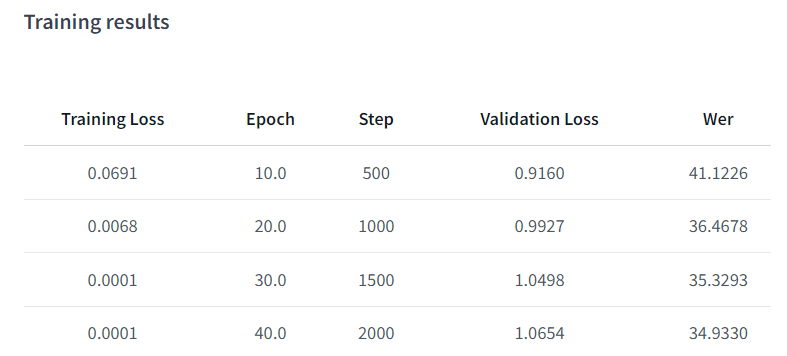

### The End